# Spotify Music Skips Action Prediction
Spotify has over 190 million active users interacting with over 40 million tracks.
The goal of the challenge is to predict the likelihood of a user skipping any given song during a listening session.
<hr></hr>

## Data
Orginally data is provided in competition hosted on [crowdai.org](https://www.crowdai.org/challenges/spotify-sequential-skip-prediction-challenge) i.e. later moved to [aicrowd.com](https://www.aicrowd.com/challenges/spotify-sequential-skip-prediction-challenge/)
It contain data description file for you to work with problem on your own.

## Methodology
  1. Getting Data
  2. Processing Data
  3. Performing EDA
  4. Model Selection
  5. Choosing Model
  6. Deployment

NOTE: There are certain Terms and Condition for which I can't share you original link for data, I have moved my data to my google drive. _But you could register youself into the competition on [this link](https://www.aicrowd.com/challenges/spotify-sequential-skip-prediction-challenge/)_.


## Setting Up the notebook

In [1]:
!pip install category_encoders

In [2]:
# Data Processing Libaries
import numpy as np
import pandas as pd

# Data Visualization Libaries
from matplotlib import pyplot as plt
import seaborn as sns

# Misc. Libaries
import os
import warnings
from google.colab import drive


warnings.filterwarnings('ignore') # ignore warnings

# Preparing Setup
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# setting randomness in notebook
np.random.seed(0)

# setting graph styling
sns.set_palette("Set2")
sns.set_style("whitegrid")


# shortcut for accessing data
drive.mount('/content/drive/')
!ln -s /content/drive/My\ Drive/spotify-skips-action-project/ /mydrive
!ls /mydrive


# Dataset File Path
SESSION_FILE_PATH = "/mydrive/training_set_1.tar.gz"
TRACK_FILE_PATH = "/mydrive/track_features.tar.gz"

print("Setup Complete!")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
ln: failed to create symbolic link '/mydrive/spotify-skips-action-project': File exists
comple_processed_data.csv  spotify-skips-action-project  training_set_1.tar.gz
preprocessing_pipeline.py  track_features.tar.gz	 utils.py
spotify_data		   training_set_0.tar.gz
Setup Complete!


## Getting Data

In [3]:
# Reading the data
session_data = pd.read_csv(SESSION_FILE_PATH,  compression='gzip', nrows=1000000)
track_data = pd.read_csv(TRACK_FILE_PATH, compression='gzip')

session_data.rename(columns={session_data.columns[0]: 'session_id'}, inplace=True)

track_data.rename(columns={'track_features/':"track_id"}, inplace=True)


print("Reading Data Completed!")

Reading Data Completed!


Entire training dataset is of 56Gb, so they have distributed data in 10 sets each of 5.6Gb. From which I have only abstracted first 1million 
rows.

I have renamed column names from each datasets.

## Preprocessing Data

In [4]:
from preprocessing_pipeline import CustomPreprocessor
from utils import *

# I have done some previous work on project so I have created some utility function for working in smooth manager.

session_data = merge_session_with_track_feature(session_data, track_data)
session_data = update_index(session_data)

In [5]:
# Processing the Data with CustomPreprocessor Pipeline
# It treat the dtypes of columns, handle categorical values, feature engineering and some other similar preprocessing stuff.
preprocessor = CustomPreprocessor()
preprocessor.fit(session_data)
preprocessed_session_data = preprocessor.transform(session_data)
preprocessed_session_data.head()

session_position  \
session_id                             track_index                     
0_00005fe5-8086-4ea4-a02f-bbe820af6067 1                           1   
                                       2                           2   
                                       3                           3   
                                       4                           4   
                                       5                           5   

                                                    session_length  \
session_id                             track_index                   
0_00005fe5-8086-4ea4-a02f-bbe820af6067 1                        13   
                                       2                        13   
                                       3                        13   
                                       4                        13   
                                       5                        13   

                                                    context_switch  \
session_id                             track_index                   
0_00005fe5-8086-4ea4-a02f-bbe820af6067 1                         0   
                                       2                         0   
                                       3                         0   
                                       4                         0   
                                       5                         0   

                                                    no_pause_before_play  \
session_id                             track_index                         
0_00005fe5-8086-4ea4-a02f-bbe820af6067 1                               0   
                                       2                               1   
                                       3                               1   
                                       4                               1   
                                       5                               1   

                                                    short_pause_before_play  \
session_id                             track_index                            
0_00005fe5-8086-4ea4-a02f-bbe820af6067 1                                  0   
                                       2                                  0   
                                       3                                  0   
                                       4                                  0   
                                       5                                  0   

                                                    long_pause_before_play  \
session_id                             track_index                           
0_00005fe5-8086-4ea4-a02f-bbe820af6067 1                                 0   
                                       2                                 0   
                                       3                                 0   
                                       4                                 0   
                                       5                                 0   

                                                    hist_user_behavior_n_seekfwd  \
session_id                             track_index                                 
0_00005fe5-8086-4ea4-a02f-bbe820af6067 1                                       1   
                                       2                                       0   
                                       3                                       0   
                                       4                                       0   
                                       5                                       0   

                                                    hist_user_behavior_n_seekback  \
session_id                             track_index                                  
0_00005fe5-8086-4ea4-a02f-bbe820af6067 1                                        1   
                                       2                                        0   
  

# Preforming EDA

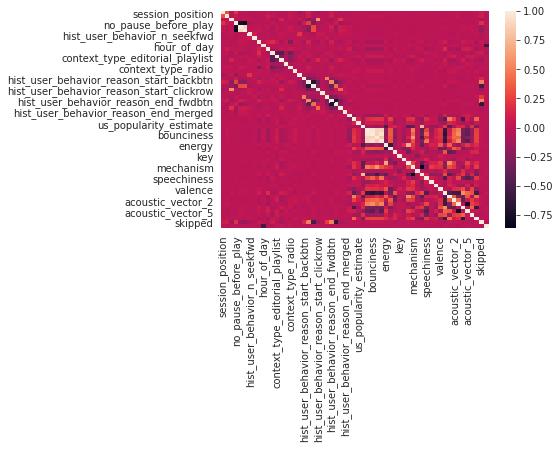

In [6]:
# Checking the correlation amoung variables
sns.heatmap(preprocessed_session_data.corr())
plt.show()

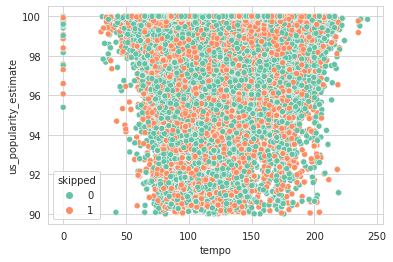

In [7]:
sns.scatterplot(x="tempo", y="us_popularity_estimate", hue="skipped", data=preprocessed_session_data)
plt.show()

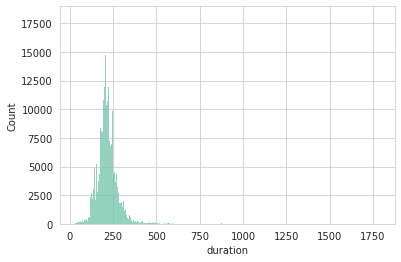

In [8]:
sns.histplot(data=preprocessed_session_data, x="duration")
plt.show()

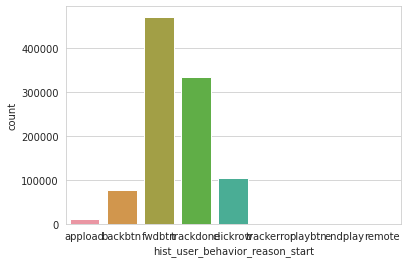

In [9]:
sns.countplot(x="hist_user_behavior_reason_start", data=session_data)
plt.show()

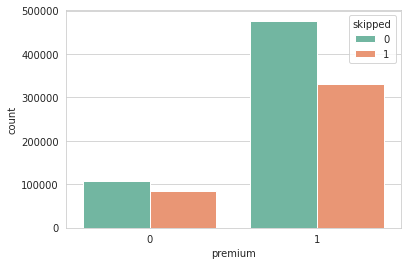

In [10]:
sns.countplot(x="premium", hue="skipped", data=preprocessed_session_data)
plt.show()

## Model Selection

In [11]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Model Libaries
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

In [12]:
y = preprocessed_session_data["skipped"]
X = preprocessed_session_data.drop("skipped", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)

In [13]:
# Random Forest Pipeline
pipeline = Pipeline([
                     ('standardize', StandardScaler()),
                     ('model', RandomForestClassifier())
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)

score = f1_score(y_test, preds)

print("Random Forest: %.2f"%score)

Random Forest: 0.85


In [14]:

# XGBoostClassifier Pipeline
xgboost_pipeline = Pipeline([
                     ('standardize', StandardScaler()),
                     ('model', XGBClassifier())
])

xgboost_pipeline.fit(X_train, y_train)
preds = xgboost_pipeline.predict(X_test)

score = f1_score(y_test, preds)

print("XGBoost: %.2f"%score)

XGBoost: 0.86


In [15]:
# LightGradientBoostMachine
print('Loading data...')

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='binary' #Binary target feature
params['metric']='binary_logloss' #metric for binary classification
params['max_depth']=10

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('Saving model...')
# save model to file
gbm.save_model('model.txt')

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred = y_pred.round(0)
# eval
print('The f1_score of prediction is: %.2f'%(f1_score(y_test, y_pred)))

Loading data...
Starting training...
[1]	valid_0's binary_logloss: 0.659798
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.642201
[3]	valid_0's binary_logloss: 0.625625
[4]	valid_0's binary_logloss: 0.609991
[5]	valid_0's binary_logloss: 0.595228
[6]	valid_0's binary_logloss: 0.581268
[7]	valid_0's binary_logloss: 0.568061
[8]	valid_0's binary_logloss: 0.555548
[9]	valid_0's binary_logloss: 0.54368
[10]	valid_0's binary_logloss: 0.53242
[11]	valid_0's binary_logloss: 0.521725
[12]	valid_0's binary_logloss: 0.511561
[13]	valid_0's binary_logloss: 0.501894
[14]	valid_0's binary_logloss: 0.492697
[15]	valid_0's binary_logloss: 0.483942
[16]	valid_0's binary_logloss: 0.475597
[17]	valid_0's binary_logloss: 0.467644
[18]	valid_0's binary_logloss: 0.460056
[19]	valid_0's binary_logloss: 0.452817
[20]	valid_0's binary_logloss: 0.445902
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.445902
Saving model...
Starting 

## Model Selection

I am using traning_set_0.tar.gz (first 1million rows) to evaluate my model.

Parameter for Model Selection
  1. Better f1_score
  2. Less training time

In [16]:
# Test Dataset File Path
TEST_SESSION_FILE_PATH = "/mydrive/training_set_0.tar.gz"

# Reading the data
test_session_data = pd.read_csv(TEST_SESSION_FILE_PATH,  compression='gzip', nrows=20000)

test_session_data.rename(columns={test_session_data.columns[0]: 'session_id'}, inplace=True)

print("Reading Test Data Completed!")

Reading Test Data Completed!


In [17]:
test_session_data.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone


In [18]:
test_session_data = merge_session_with_track_feature(test_session_data, track_data)
test_session_data = update_index(test_session_data)
print("Merging Complete!")

Merging Complete!


In [19]:
preprocessor = CustomPreprocessor()
preprocessor.fit(test_session_data)
preprocessed_session_data = preprocessor.transform(test_session_data)
preprocessed_session_data.head()

session_position  \
session_id                             track_index                     
0_00006f66-33e5-4de7-a324-2d18e439fc1e 1                           1   
                                       2                           2   
                                       3                           3   
                                       4                           4   
                                       5                           5   

                                                    session_length  \
session_id                             track_index                   
0_00006f66-33e5-4de7-a324-2d18e439fc1e 1                        20   
                                       2                        20   
                                       3                        20   
                                       4                        20   
                                       5                        20   

                                                    context_switch  \
session_id                             track_index                   
0_00006f66-33e5-4de7-a324-2d18e439fc1e 1                         0   
                                       2                         0   
                                       3                         0   
                                       4                         0   
                                       5                         0   

                                                    no_pause_before_play  \
session_id                             track_index                         
0_00006f66-33e5-4de7-a324-2d18e439fc1e 1                               0   
                                       2                               1   
                                       3                               1   
                                       4                               1   
                                       5                               1   

                                                    short_pause_before_play  \
session_id                             track_index                            
0_00006f66-33e5-4de7-a324-2d18e439fc1e 1                                  0   
                                       2                                  0   
                                       3                                  0   
                                       4                                  0   
                                       5                                  0   

                                                    long_pause_before_play  \
session_id                             track_index                           
0_00006f66-33e5-4de7-a324-2d18e439fc1e 1                                 0   
                                       2                                 0   
                                       3                                 0   
                                       4                                 0   
                                       5                                 0   

                                                    hist_user_behavior_n_seekfwd  \
session_id                             track_index                                 
0_00006f66-33e5-4de7-a324-2d18e439fc1e 1                                       0   
                                       2                                       0   
                                       3                                       0   
                                       4                                       0   
                                       5                                       0   

                                                    hist_user_behavior_n_seekback  \
session_id                             track_index                                  
0_00006f66-33e5-4de7-a324-2d18e439fc1e 1                                        0   
                                       2                                        0   
  

In [20]:
y = preprocessed_session_data["skipped"]
X = preprocessed_session_data.drop("skipped", axis=1)

In [21]:
preds = pipeline.predict(X)

score = f1_score(y, preds)

print("Random Forest: %.2f"%score)

Random Forest: 0.49


In [22]:
preds = xgboost_pipeline.predict(X)

score = f1_score(y, preds)

print("XGBoost: %.2f"%score)

XGBoost: 0.53


In [25]:
y_pred = gbm.predict(X, num_iteration=gbm.best_iteration)
y_pred = y_pred.round(0)
# eval
print('LightGradientBoostMachine: %.2f'%(f1_score(y, y_pred)))

LightGradientBoostMachine: 0.53


In [26]:
import pickle
model_pkl_filename = 'spotify_skip_prediction_model.pkl'
model_pkl = open(model_pkl_filename, 'wb')
pickle.dump(gbm, model_pkl)
model_pkl.close()